In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
try:
    df_campaign = pd.read_csv('clusteringcampaign.csv', delimiter='\t')
    print("\nDataset 'clusteringcampaign.csv' berhasil dimuat!")
except FileNotFoundError:
    print("\nError: File 'clusteringcampaign.csv' tidak ditemukan. Pastikan Anda telah mengunggahnya ke Colab.")
    exit()

print("\nLima baris pertama dataset 'clusteringcampaign.csv':")
print(df_campaign.head())


Dataset 'clusteringcampaign.csv' berhasil dimuat!

Lima baris pertama dataset 'clusteringcampaign.csv':
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5

In [4]:
# Informasi dataset
print("\nInformasi dataset 'clusteringcampaign.csv':")
df_campaign.info()

# Statistik deskriptif
print("\nStatistik deskriptif dataset 'clusteringcampaign.csv':")
print(df_campaign.describe())


Informasi dataset 'clusteringcampaign.csv':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64 

# Pra-pemrosesan Data

In [5]:
# Buat salinan DataFrame untuk pra-pemrosesan
df_processed = df_campaign.copy()

# 2.1 Tangani Nilai yang Hilang: Drop baris dengan Income yang hilang
df_processed.dropna(subset=['Income'], inplace=True)
print(f"\nJumlah baris setelah menghilangkan nilai Income yang hilang: {len(df_processed)}")

# Konversi Income ke integer
df_processed['Income'] = df_processed['Income'].astype(int)


Jumlah baris setelah menghilangkan nilai Income yang hilang: 2216


In [6]:
# 2.2 Feature Engineering
# Hitung Umur pelanggan (asumsi tahun saat ini adalah 2025)
current_year = 2025
df_processed['Age'] = current_year - df_processed['Year_Birth']

# Hitung Total Pengeluaran (Total Monetary)
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_processed['TotalMnt'] = df_processed[mnt_cols].sum(axis=1)

# Hitung Total Pembelian
num_purchases_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df_processed['TotalPurchases'] = df_processed[num_purchases_cols].sum(axis=1)

# Hitung Total Anak (Kids)
df_processed['Kids'] = df_processed['Kidhome'] + df_processed['Teenhome']

In [7]:
# 2.3 Tangani Fitur Kategorikal: One-Hot Encoding untuk 'Education' dan 'Marital_Status'
# Pastikan tidak ada spasi di awal/akhir nilai kategorikal
df_processed['Education'] = df_processed['Education'].str.strip()
df_processed['Marital_Status'] = df_processed['Marital_Status'].str.strip()

# Kolom 'Marital_Status' memiliki entri 'YOLO' dan 'Alone' yang sangat jarang,
# bisa menyebabkan klaster yang sangat kecil atau masalah dengan one-hot encoding jika tidak diatasi.
# Untuk tujuan ini, kita akan tetap melakukan one-hot encoding, tetapi perlu dicatat.
df_processed = pd.get_dummies(df_processed, columns=['Education', 'Marital_Status'], drop_first=True)


In [8]:
# 2.4 Hapus Kolom yang Tidak Relevan/Redundan/Konstan
columns_to_drop = [
    'ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', # Irrelevant/Redundant
    'Kidhome', 'Teenhome' # Digantikan oleh 'Kids'
] + mnt_cols + num_purchases_cols # Digantikan oleh 'TotalMnt' dan 'TotalPurchases'

df_processed.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Konversi kolom boolean (dari one-hot encoding) menjadi int
for col in df_processed.select_dtypes(include='bool').columns:
    df_processed[col] = df_processed[col].astype(int)

print("\nLima baris pertama dataset setelah pra-pemrosesan:")
print(df_processed.head())

print("\nInformasi dataset setelah pra-pemrosesan:")
df_processed.info()



Lima baris pertama dataset setelah pra-pemrosesan:
   Income  Recency  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0   58138       58                  7             0             0   
1   46344       38                  5             0             0   
2   71613       26                  4             0             0   
3   26646       26                  6             0             0   
4   58293       94                  5             0             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  ...  \
0             0             0             0         0         1  ...   
1             0             0             0         0         0  ...   
2             0             0             0         0         0  ...   
3             0             0             0         0         0  ...   
4             0             0             0         0         0  ...   

   Education_Graduation  Education_Master  Education_PhD  \
0                     1                 

In [9]:
# 2.5 Penskalaan Fitur-fitur untuk Clustering
numerical_cols_for_clustering = df_processed.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed[numerical_cols_for_clustering])
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols_for_clustering, index=df_processed.index)

print("\nLima baris pertama data yang telah diskalakan untuk clustering:")
print(X_scaled_df.head())
print("\nStatistik deskriptif data yang telah diskalakan:")
print(X_scaled_df.describe())


Lima baris pertama data yang telah diskalakan untuk clustering:
     Income   Recency  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0  0.234063  0.310532           0.693232     -0.281773     -0.282705   
1 -0.234559 -0.380509          -0.131574     -0.281773     -0.282705   
2  0.769478 -0.795134          -0.543978     -0.281773     -0.282705   
3 -1.017239 -0.795134           0.280829     -0.281773     -0.282705   
4  0.240221  1.554407          -0.131574     -0.281773     -0.282705   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  ...  \
0     -0.280839     -0.261661     -0.117148 -0.097812  2.377952  ...   
1     -0.280839     -0.261661     -0.117148 -0.097812 -0.420530  ...   
2     -0.280839     -0.261661     -0.117148 -0.097812 -0.420530  ...   
3     -0.280839     -0.261661     -0.117148 -0.097812 -0.420530  ...   
4     -0.280839     -0.261661     -0.117148 -0.097812 -0.420530  ...   

   Education_Graduation  Education_Master  Education_PhD  \
0        

# Pembuatan 2 Model Clustering Machine Learnin


--- Memulai K-Means Clustering ---


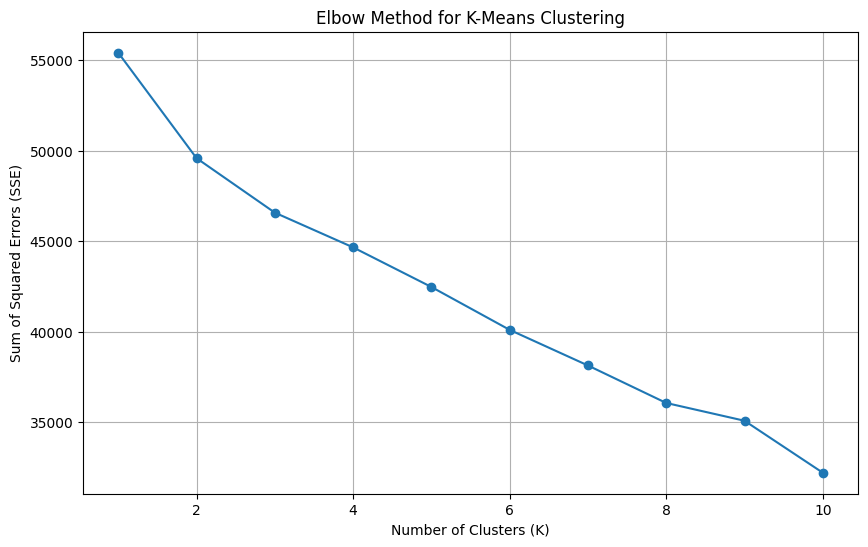

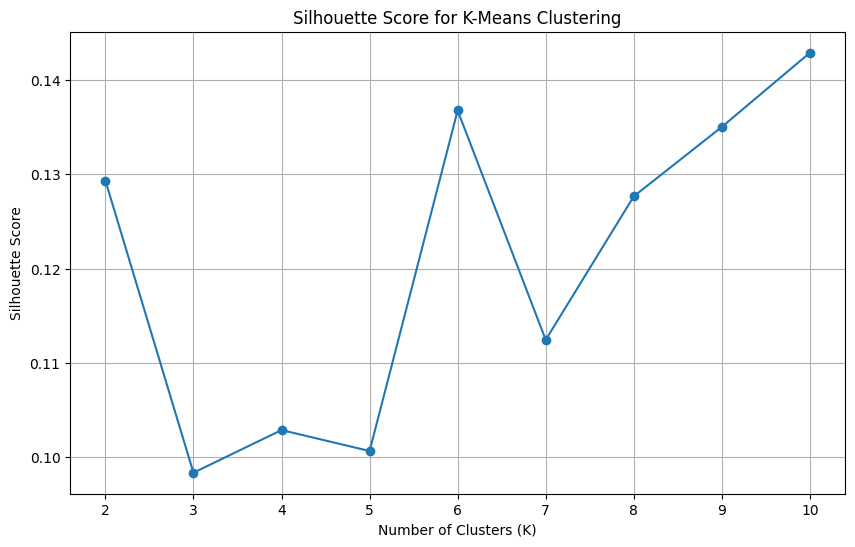


Jumlah anggota di setiap klaster K-Means (K=4):
KMeans_Cluster
1    958
2    630
0    431
3    197
Name: count, dtype: int64

Karakteristik klaster K-Means (rata-rata fitur asli sebelum penskalaan):
                  Income    Age  Recency  TotalMnt  TotalPurchases  Kids  \
KMeans_Cluster                                                             
0               53550.67  59.33    48.47    587.12           15.39  1.09   
1               34993.35  53.16    49.59    142.72            9.27  1.22   
2               68839.61  58.71    48.95   1025.29           21.20  0.66   
3               80238.53  55.89    47.61   1571.42           20.86  0.22   

                NumWebVisitsMonth  AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  \
KMeans_Cluster                                                                
0                            5.40          0.02          0.00          0.08   
1                            6.63          0.00          0.00          0.07   
2                          

In [10]:
# Model 1: K-Means Clustering
print("\n--- Memulai K-Means Clustering ---")

# 3.1.1 Elbow Method untuk K-Means
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.savefig('kmeans_elbow_method.png')
plt.show()

# 3.1.2 Silhouette Score untuk K-Means
silhouette_scores_kmeans = []
for k in range(2, 11): # Silhouette score tidak dapat dihitung untuk k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    score = silhouette_score(X_scaled_df, kmeans.labels_)
    silhouette_scores_kmeans.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Score for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig('kmeans_silhouette_score.png')
plt.show()

# Berdasarkan Elbow Method dan Silhouette Score, mari kita pilih K=4 sebagai contoh untuk analisis lebih lanjut.
# (Anda dapat menyesuaikan K ini berdasarkan interpretasi Anda terhadap plot)
optimal_k_kmeans = 4
kmeans_model = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X_scaled_df)
df_processed['KMeans_Cluster'] = kmeans_labels

print(f"\nJumlah anggota di setiap klaster K-Means (K={optimal_k_kmeans}):")
print(df_processed['KMeans_Cluster'].value_counts())

print("\nKarakteristik klaster K-Means (rata-rata fitur asli sebelum penskalaan):")
# Gunakan df_campaign yang sudah dibersihkan (tapi sebelum skala) untuk rata-rata fitur yang mudah diinterpretasi
# Re-align index jika df_processed mengalami perubahan ukuran
df_original_subset = df_campaign.loc[df_processed.index].copy()
cluster_summary_kmeans = df_processed.groupby('KMeans_Cluster').agg({
    'Income': 'mean',
    'Age': 'mean',
    'Recency': 'mean',
    'TotalMnt': 'mean',
    'TotalPurchases': 'mean',
    'Kids': 'mean',
    'NumWebVisitsMonth': 'mean',
    'AcceptedCmp1': 'mean',
    'AcceptedCmp2': 'mean',
    'AcceptedCmp3': 'mean',
    'AcceptedCmp4': 'mean',
    'AcceptedCmp5': 'mean',
    'Response': 'mean',
    'Complain': 'mean',
    # Kolom hasil one-hot encoding
    'Education_Graduation': 'mean',
    'Education_Master': 'mean',
    'Education_PhD': 'mean',
    'Marital_Status_Married': 'mean',
    'Marital_Status_Single': 'mean',
    'Marital_Status_Together': 'mean',
    'Marital_Status_Divorced': 'mean',
    'Marital_Status_Widow': 'mean',
    'Marital_Status_Alone': 'mean',
    'Marital_Status_YOLO': 'mean',

}).round(2)
print(cluster_summary_kmeans)


--- Memulai Hierarchical Clustering ---


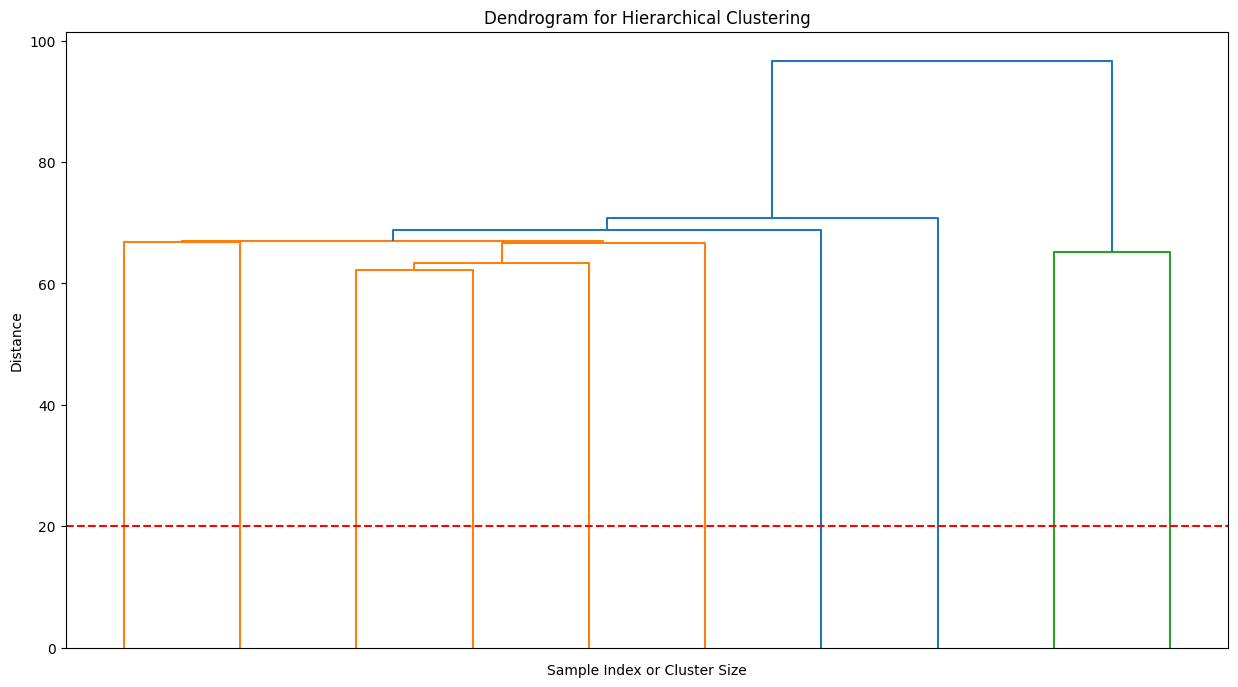


Jumlah anggota di setiap klaster Hierarchical Clustering (N_Clusters=4):
HC_Cluster
0    1851
1     237
3      74
2      54
Name: count, dtype: int64

Karakteristik klaster Hierarchical Clustering (rata-rata fitur asli sebelum penskalaan):
              Income    Age  Recency  TotalMnt  TotalPurchases  Kids  \
HC_Cluster                                                             
0           49319.54  56.02    49.10    504.63           14.27  1.04   
1           80987.78  56.27    48.45   1490.86           20.84  0.30   
2           20306.26  47.54    48.44     81.80            7.02  0.72   
3           56740.61  66.30    48.97    722.39           16.78  0.91   

            NumWebVisitsMonth  AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  ...  \
HC_Cluster                                                               ...   
0                        5.53          0.00          0.00          0.07  ...   
1                        3.45          0.58          0.13          0.14  ...   
2     

In [11]:
# Model 2: Hierarchical Clustering (Agglomerative Clustering)
print("\n--- Memulai Hierarchical Clustering ---")

# 3.2.1 Visualisasi Dendrogram untuk menentukan jumlah klaster
plt.figure(figsize=(15, 8))
linked = linkage(X_scaled_df, method='ward')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           p=10,
           truncate_mode='lastp'
          )
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=20, color='r', linestyle='--') # Garis bantu untuk visualisasi pemotongan
plt.savefig('hierarchical_dendrogram.png')
plt.show()

# 3.2.2 Menerapkan AgglomerativeClustering
# Berdasarkan dendrogram, mari kita pilih N_Clusters=4 untuk perbandingan langsung dengan K-Means.
# (Anda dapat menyesuaikan N_Clusters ini berdasarkan interpretasi Anda terhadap dendrogram)
optimal_n_clusters_hc = 4
hc_model = AgglomerativeClustering(n_clusters=optimal_n_clusters_hc, linkage='ward') # affinity dihapus
hc_labels = hc_model.fit_predict(X_scaled_df)
df_processed['HC_Cluster'] = hc_labels

print(f"\nJumlah anggota di setiap klaster Hierarchical Clustering (N_Clusters={optimal_n_clusters_hc}):")
print(df_processed['HC_Cluster'].value_counts())

print("\nKarakteristik klaster Hierarchical Clustering (rata-rata fitur asli sebelum penskalaan):")
cluster_summary_hc = df_processed.groupby('HC_Cluster').agg({
    'Income': 'mean',
    'Age': 'mean',
    'Recency': 'mean',
    'TotalMnt': 'mean',
    'TotalPurchases': 'mean',
    'Kids': 'mean',
    'NumWebVisitsMonth': 'mean',
    'AcceptedCmp1': 'mean',
    'AcceptedCmp2': 'mean',
    'AcceptedCmp3': 'mean',
    'AcceptedCmp4': 'mean',
    'AcceptedCmp5': 'mean',
    'Response': 'mean',
    'Complain': 'mean',
    # Kolom hasil one-hot encoding
    'Education_Graduation': 'mean',
    'Education_Master': 'mean',
    'Education_PhD': 'mean',
    'Marital_Status_Married': 'mean',
    'Marital_Status_Single': 'mean',
    'Marital_Status_Together': 'mean',
    'Marital_Status_Divorced': 'mean',
    'Marital_Status_Widow': 'mean',
    'Marital_Status_Alone': 'mean',
    'Marital_Status_YOLO': 'mean',
}).round(2)
print(cluster_summary_hc)

# --- Langkah 4: Evaluasi Metrik Lain ---
print("\n--- Evaluasi Metrik untuk K-Means (K=2 hingga K=10) ---")
kmeans_metrics = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled_df)

    sil_score = silhouette_score(X_scaled_df, kmeans_labels)
    ch_score = calinski_harabasz_score(X_scaled_df, kmeans_labels)
    db_score = davies_bouldin_score(X_scaled_df, kmeans_labels)
    kmeans_metrics.append({'K': k, 'Silhouette': sil_score, 'Calinski-Harabasz': ch_score, 'Davies-Bouldin': db_score})

    print(f"K={k}: Sil={sil_score:.4f}, CH={ch_score:.4f}, DB={db_score:.4f}")

print("\n--- Evaluasi Metrik untuk Hierarchical Clustering (N_Clusters=2 hingga N_Clusters=10) ---")
hc_metrics = []
for n_c in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=n_c, linkage='ward')
    hc_labels = hc.fit_predict(X_scaled_df)

    sil_score = silhouette_score(X_scaled_df, hc_labels)
    ch_score = calinski_harabasz_score(X_scaled_df, hc_labels)
    db_score = davies_bouldin_score(X_scaled_df, hc_labels)
    hc_metrics.append({'N_Clusters': n_c, 'Silhouette': sil_score, 'Calinski-Harabasz': ch_score, 'Davies-Bouldin': db_score})

    print(f"N_Clusters={n_c}: Sil={sil_score:.4f}, CH={ch_score:.4f}, DB={db_score:.4f}")

# Simpan hasil metrik ke DataFrame untuk analisis lebih lanjut jika diperlukan
kmeans_metrics_df = pd.DataFrame(kmeans_metrics)
hc_metrics_df = pd.DataFrame(hc_metrics)

print("\nRingkasan Metrik K-Means:")
print(kmeans_metrics_df)

print("\nRingkasan Metrik Hierarchical Clustering:")
print(hc_metrics_df)

### **Matrik Mana yang Terbaik!**

Kesimpulan karakteristik dan kecenderungan masing-masing metrik untuk membantu pengambilan keputusan:

**Ringkasan Hasil Metrik pada Dataset Ini:**

* **K-Means:**
    * Silhouette Score maksimum: ~0.14 (pada K=10)
    * Calinski-Harabasz maksimum: ~260 (pada K=2)
    * Davies-Bouldin minimum: ~1.51 (pada K=10)
* **Hierarchical Clustering:**
    * Silhouette Score maksimum: ~0.29 (pada N_Clusters=7)
    * Calinski-Harabasz maksimum: ~203 (pada N_Clusters=2)
    * Davies-Bouldin minimum: ~1.07 (pada N_Clusters=8)

**Analisis dan Rekomendasi:**

1.  **Silhouette Coefficient**:
    * **Kelebihan**: Memberikan intuisi yang baik tentang seberapa baik setiap titik dikelompokkan (kohesi dan separasi). Mudah diinterpretasikan.
    * **Perbandingan**: Pada dataset ini, **Hierarchical Clustering menunjukkan skor Silhouette yang secara konsisten lebih tinggi** (maksimum ~0.29) dibandingkan K-Means (maksimum ~0.14). Ini menunjukkan bahwa, dari perspektif kohesi dan separasi, klaster yang dihasilkan oleh Hierarchical Clustering lebih baik.

2.  **Calinski-Harabasz Index**:
    * **Kelebihan**: Cepat dihitung, nilai lebih tinggi lebih baik.
    * **Perbandingan**: K-Means memiliki skor Calinski-Harabasz yang sedikit lebih tinggi pada jumlah klaster yang lebih rendah (misalnya, K=2).

3.  **Davies-Bouldin Index**:
    * **Kelebihan**: Semakin rendah nilainya, semakin baik klasterisasi.
    * **Perbandingan**: **Hierarchical Clustering mencapai skor Davies-Bouldin yang lebih rendah (lebih baik)** dibandingkan K-Means, terutama pada jumlah klaster yang lebih tinggi.

**Kesimpulan:**

Berdasarkan hasil evaluasi pada dataset `clusteringcampaign.csv`:

* **Hierarchical Clustering (Agglomerative Clustering)** cenderung menghasilkan klaster dengan kualitas yang sedikit lebih baik dibandingkan K-Means, terutama jika dilihat dari **Silhouette Score** (yang mengindikasikan kohesi dan separasi yang lebih baik) dan **Davies-Bouldin Index** (yang menunjukkan klaster yang lebih kompak dan terpisah). Jumlah klaster optimal untuk Hierarchical Clustering mungkin berada di kisaran 7-8 berdasarkan Silhouette dan Davies-Bouldin.

## Penjelasan Persamaan Matematika

Berikut adalah penjelasan rinci untuk setiap persamaan matematika yang digunakan dalam pra-pemrosesan data dan evaluasi model clustering:

---

### 1. StandardScaler (Normalisasi Data)

**Tujuan:** Mengubah skala data sehingga setiap fitur memiliki rata-rata nol ($\mu=0$) dan standar deviasi satu ($\sigma=1$). Ini penting untuk algoritma berbasis jarak agar fitur dengan rentang nilai besar tidak mendominasi perhitungan.

**Persamaan:**
$$z = \frac{x - \mu}{\sigma}$$

**Penjelasan Variabel:**
* $z$: Nilai fitur yang sudah diskalakan (standardized score).
* $x$: Nilai asli dari sebuah data point untuk fitur tertentu.
* $\mu$ (mu): Rata-rata (mean) dari semua nilai untuk fitur tersebut dalam dataset.
    * **Rumus Rata-rata ($\mu$)**:
        $$\mu = \frac{1}{N} \sum_{i=1}^{N} x_i$$
        Di mana $N$ adalah jumlah total data point, dan $x_i$ adalah nilai dari data point ke-$i$.
* $\sigma$ (sigma): Standar deviasi dari semua nilai untuk fitur tersebut dalam dataset.
    * **Rumus Standar Deviasi ($\sigma$)**:
        $$\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$$
        (Untuk sampel, pembaginya biasanya $N-1$, tetapi untuk populasi atau dalam konteks transformasi data secara keseluruhan, $N$ sering digunakan.)

**Bagaimana Ini Bekerja:**
Setiap nilai data dikurangi dengan rata-rata fitur tersebut, kemudian hasilnya dibagi dengan standar deviasi fitur tersebut. Ini menempatkan semua fitur pada skala yang sama, sehingga mereka memberikan kontribusi yang setara pada perhitungan jarak oleh algoritma clustering.

---

### 2. Jarak Euclidean (Euclidean Distance)

**Tujuan:** Mengukur "jarak garis lurus" antara dua titik dalam ruang $n$-dimensi. Ini adalah metrik jarak paling umum yang digunakan dalam K-Means dan banyak algoritma berbasis jarak lainnya.

**Persamaan:**
$$d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2}$$

**Penjelasan Variabel:**
* $d(\mathbf{p}, \mathbf{q})$: Jarak Euclidean antara dua titik $\mathbf{p}$ dan $\mathbf{q}$.
* $\mathbf{p} = (p_1, p_2, \ldots, p_n)$: Titik pertama dalam ruang $n$-dimensi, di mana $p_i$ adalah koordinatnya pada dimensi ke-$i$.
* $\mathbf{q} = (q_1, q_2, \ldots, q_n)$: Titik kedua dalam ruang $n$-dimensi, di mana $q_i$ adalah koordinatnya pada dimensi ke-$i$.
* $n$: Jumlah dimensi (fitur) dalam data.
* $\sum_{i=1}^{n}$: Simbol penjumlahan yang berarti kita menjumlahkan hasil perhitungan untuk setiap dimensi dari 1 hingga $n$.
* $(q_i - p_i)^2$: Kuadrat dari perbedaan antara koordinat pada dimensi ke-$i$ untuk kedua titik. Mengkuadratkan perbedaan memastikan bahwa jarak selalu positif dan memberikan bobot lebih pada perbedaan yang lebih besar.

**Bagaimana Ini Bekerja:**
Untuk setiap dimensi, kita menghitung selisih antara koordinat kedua titik, lalu mengkuadratkan selisih tersebut. Semua hasil kuadrat ini dijumlahkan, dan akar kuadrat dari total penjumlahan diambil. Ini secara efektif menghitung panjang hipotenusa dari segitiga $n$-dimensi yang dibentuk oleh kedua titik.

---

### 3. Sum of Squared Errors (SSE) / Inertia (untuk K-Means)

**Tujuan:** Mengukur kekompakan (cohesion) klaster dalam K-Means. Ini adalah metrik yang diminimalkan oleh algoritma K-Means.

**Persamaan:**
$$SSE = \sum_{j=1}^{K} \sum_{i=1}^{n_j} ||x_i - c_j||^2$$

**Penjelasan Variabel:**
* $SSE$: Sum of Squared Errors, atau dikenal juga sebagai *inertia* dalam scikit-learn.
* $K$: Jumlah total klaster.
* $\sum_{j=1}^{K}$: Penjumlahan yang dilakukan untuk setiap klaster, dari klaster 1 hingga klaster $K$.
* $\sum_{i=1}^{n_j}$: Penjumlahan yang dilakukan untuk setiap titik data ($x_i$) di dalam klaster $j$.
* $n_j$: Jumlah titik data di klaster $j$.
* $x_i$: Titik data ke-$i$ yang termasuk dalam klaster $j$.
* $c_j$: Centroid (rata-rata) dari klaster $j$.
* $||x_i - c_j||^2$: Jarak Euclidean kuadrat antara titik data $x_i$ dan centroid klaster $c_j$-nya.

**Bagaimana Ini Bekerja:**
Untuk setiap klaster, kita menghitung jarak kuadrat antara setiap titik data di klaster tersebut dan centroid klaster. Kemudian, semua jarak kuadrat ini dijumlahkan. Nilai SSE yang lebih kecil menunjukkan klaster yang lebih padat, di mana titik-titik data lebih dekat ke centroid klaster masing-masing. Dalam Elbow Method, kita mencari titik di mana penurunan SSE mulai melambat secara signifikan.

---

### 4. Silhouette Coefficient

**Tujuan:** Mengukur seberapa baik setiap titik data cocok dengan klaster yang ditugaskan kepadanya, dengan mempertimbangkan seberapa jauh ia dari klaster lain. Ini mengukur baik kohesi (keterikatan intra-klaster) maupun separasi (pemisahan antar-klaster).

**Persamaan:**
$$s = \frac{b - a}{\max(a, b)}$$

**Penjelasan Variabel:**
* $s$: Nilai Silhouette Coefficient untuk satu titik data. Nilai ini dihitung untuk setiap titik data.
* $a$: Jarak rata-rata antara titik data tersebut dan semua titik lain di **klaster yang sama**.
    * **Penjelasan:** Ini adalah ukuran *kohesi* intra-klaster. Semakin kecil $a$, semakin baik titik data tersebut cocok dengan klaster sendiri.
* $b$: Jarak rata-rata antara titik data tersebut dan semua titik di **klaster terdekat berikutnya** (klaster tetangga).
    * **Penjelasan:** Klaster tetangga adalah klaster lain yang centroidnya paling dekat dengan titik data tersebut. $b$ adalah ukuran *separasi* antar-klaster. Semakin besar $b$, semakin jauh titik data dari klaster lain.
* $\max(a, b)$: Mengambil nilai maksimum antara $a$ dan $b$ sebagai pembagi untuk menormalisasi skor antara -1 dan 1.

**Rentang dan Interpretasi:**
* **$s \approx 1$**: Titik data dikelompokkan dengan sangat baik. Jarak ke titik-titik di klaster sendiri jauh lebih kecil daripada jarak ke klaster lain.
* **$s \approx 0$**: Titik data berada sangat dekat dengan batas antara dua klaster. Ini menunjukkan klaster yang tumpang tindih atau tidak jelas.
* **$s \approx -1$**: Titik data mungkin telah ditugaskan ke klaster yang salah. Jarak ke klaster lain lebih kecil daripada jarak ke klaster sendiri.

**Silhouette Score Keseluruhan:**
Untuk mengevaluasi seluruh clustering, kita mengambil rata-rata nilai Silhouette Coefficient dari semua titik data. Nilai rata-rata ini disebut "Silhouette Score". Kita mencari jumlah klaster ($K$) yang memberikan Silhouette Score tertinggi.

---

### 5. Calinski-Harabasz Index (Variance Ratio Criterion)

**Tujuan:** Mengukur rasio antara varians antar-klaster (between-cluster variance) dan varians dalam-klaster (within-cluster variance).

**Persamaan:**
$$CH = \frac{tr(B_k)}{tr(W_k)} \times \frac{N - K}{K - 1}$$

**Penjelasan Variabel:**
* $CH$: Nilai Calinski-Harabasz Index.
* $tr(B_k)$: **Jejak (trace) dari matriks penyebaran antar-klaster (between-cluster dispersion matrix).**
    * **Konsep:** Mengukur seberapa jauh klaster terpisah satu sama lain. Nilai yang lebih besar menunjukkan separasi yang lebih baik antar klaster. Ini dihitung dengan menjumlahkan kuadrat jarak antara centroid setiap klaster dan centroid global data, dikalikan dengan jumlah titik di klaster tersebut.
* $tr(W_k)$: **Jejak dari matriks penyebaran dalam-klaster (within-cluster dispersion matrix).**
    * **Konsep:** Mengukur seberapa padat (kohesif) klaster-klaster tersebut. Nilai yang lebih kecil menunjukkan klaster yang lebih kompak. Ini dihitung dengan menjumlahkan kuadrat jarak setiap titik data ke centroid klaster-nya di seluruh klaster.
* $N$: Jumlah total titik data dalam dataset.
* $K$: Jumlah klaster.
* $\frac{N - K}{K - 1}$: Faktor normalisasi.

**Interpretasi:**
* **Nilai yang lebih tinggi menunjukkan klaster yang lebih baik.** Sebuah clustering yang baik akan memiliki klaster-klaster yang sangat terpisah (nilai $tr(B_k)$ tinggi) dan klaster-klaster yang sangat padat (nilai $tr(W_k)$ rendah), menghasilkan rasio yang besar.

---

### 6. Davies-Bouldin Index

**Tujuan:** Mengukur "kesamaan" rata-rata antara setiap klaster dan klaster yang paling mirip dengannya. Ini didefinisikan sebagai rasio antara dispersi intra-klaster (ukuran penyebaran titik dalam klaster) dan jarak antar-klaster.

**Persamaan:**
$$DB = \frac{1}{K} \sum_{i=1}^{K} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)$$

**Penjelasan Variabel:**
* $DB$: Nilai Davies-Bouldin Index.
* $K$: Jumlah klaster.
* $\sum_{i=1}^{K}$: Penjumlahan yang dilakukan untuk setiap klaster dari 1 hingga $K$.
* $\max_{j \neq i} (...)$: Mengambil nilai maksimum dari rasio di dalam kurung untuk semua klaster $j$ yang berbeda dari klaster $i$.
* $\sigma_i$: Rata-rata jarak dari setiap titik di klaster $i$ ke centroid klaster $i$.
    * **Konsep:** Ini adalah ukuran *dispersi intra-klaster* atau seberapa "menyebar" titik-titik di dalam klaster $i$. Nilai yang lebih kecil menunjukkan klaster yang lebih kompak.
* $\sigma_j$: Rata-rata jarak dari setiap titik di klaster $j$ ke centroid klaster $j$.
* $d(c_i, c_j)$: Jarak (biasanya Euclidean) antara centroid klaster $i$ dan centroid klaster $j$.
    * **Konsep:** Ini adalah ukuran *separasi antar-klaster*. Nilai yang lebih besar menunjukkan klaster yang lebih terpisah.

**Interpretasi:**
* **Nilai yang lebih rendah menunjukkan klaster yang lebih baik.** Jika klaster-klaster kompak ($\sigma_i$ dan $\sigma_j$ kecil) dan terpisah jauh ($d(c_i, c_j)$ besar), maka rasio $\frac{\sigma_i + \sigma_j}{d(c_i, c_j)}$ akan kecil. Rata-rata dari rasio-rasio minimum ini akan menghasilkan skor DB yang rendah.

---

### 7. Dunn Index (Konseptual)

**Tujuan:** Mencari klaster yang kompak dan terpisah dengan baik, sebagai rasio antara jarak minimum antar-klaster dan diameter maksimum klaster.

**Persamaan (Konseptual):**
$$D = \frac{\min_{i \neq j} \left( \text{jarak antar klaster}(C_i, C_j) \right)}{\max_{k} \left( \text{diameter klaster}(C_k) \right)}$$

**Penjelasan Variabel:**
* $D$: Nilai Dunn Index.
* $\min_{i \neq j} \left( \text{jarak antar klaster}(C_i, C_j) \right)$: Jarak minimum antara dua titik yang berada di **dua klaster yang berbeda** ($C_i$ dan $C_j$).
    * **Konsep:** Ini mengukur seberapa baik klaster-klaster terpisah. Kita ingin nilai ini besar (klaster-klaster jauh satu sama lain).
* $\max_{k} \left( \text{diameter klaster}(C_k) \right)$: Diameter maksimum dari **setiap klaster** ($C_k$). Diameter klaster adalah jarak terbesar antara dua titik mana pun di dalam klaster yang sama.
    * **Konsep:** Ini mengukur seberapa kompak klaster. Kita ingin nilai ini kecil (klaster-klaster padat).

**Interpretasi:**
* **Nilai yang lebih tinggi menunjukkan klaster yang lebih baik.** Sebuah clustering yang ideal akan memiliki jarak antar-klaster yang besar dan diameter klaster yang kecil, menghasilkan skor Dunn Index yang tinggi.

**Catatan:** Dunn Index tidak secara langsung tersedia di scikit-learn karena kompleksitas komputasinya, terutama untuk dataset besar, dan sensitivitasnya terhadap outlier.

---